In [306]:
import math 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
plt.style.use('fivethirtyeight') # специальное отображение графиков для pyplot

In [247]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [248]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SMA-EMA/Adj_close_9.csv", index_col=['Date'])
df

,AAPL,BA,CVX,JNJ,MCD,MMM,MRK,NIKE,PFE
Date,,,,,,,,,
02.01.1980,0.095495,1.887721,1.540306,0.606842,0.504497,1.687597,0.538131,0.129549,0.210424
03.01.1980,0.095495,1.911495,1.543855,0.607831,0.503021,1.619411,0.545737,0.129549,0.210424
04.01.1980,0.095495,2.096938,1.536757,0.616726,0.510397,1.619411,0.549540,0.129549,0.218139
07.01.1980,0.095495,2.173017,1.536757,0.615738,0.505972,1.627934,0.554294,0.129549,0.218139
08.01.1980,0.095495,2.206303,1.550953,0.640446,0.513348,1.687597,0.570457,0.129549,0.228660
...,...,...,...,...,...,...,...,...,...
03.05.2021,132.315247,235.190002,105.529999,165.210007,235.559998,198.610001,75.980003,133.029999,39.441368
04.05.2021,127.633202,233.630005,106.110001,167.770004,233.860001,199.380005,75.989998,131.550003,39.560196
05.05.2021,127.882790,228.179993,108.959999,167.070007,235.039993,201.440002,77.699997,132.210007,39.580002


In [249]:
df.index=pd.to_datetime(df.index,format='%d.%m.%Y')
df=df.astype('float32')

In [250]:
def SMA(X, w=5):
    return np.sum(X[len(X)-w:])/w

In [251]:
def EMA(X, t=5, alpha=0.2):
    result=np.zeros((1,X.shape[1]),dtype=float)
    for i in range(min(t,len(X))):
        result+=alpha*((1-alpha)**i)*X[len(X)-i-1:len(X)-i].values
    return result

In [252]:
def DEMA(X, t=5, alpha=0.2):
    result=2*EMA(X,t,alpha)
    ema_arrays=np.zeros((t,X.shape[1]),dtype=float)
    for i in range(t):
        ema_arrays[i]+=EMA(X[:(len(X) if i==0 else -i)],t,alpha)[0]
    result-=EMA(pd.DataFrame(ema_arrays),t,alpha)
    return result

In [253]:
def TEMA(X,t=5,alpha=0.2):
    result=3*EMA(X,t,alpha)
    ema_arrays=np.zeros((t*2,X.shape[1]),dtype=float)
    ema_arrays2=np.zeros((t,X.shape[1]),dtype=float)
    for i in range(t*2):
        ema_arrays[i]+=EMA(X[:(len(X) if i==0 else -i)],t,alpha)[0]
    result-=3*EMA(pd.DataFrame(ema_arrays),t,alpha)
    for i in range(t):
        ema_arrays2[i]+=EMA(pd.DataFrame(ema_arrays[:(len(X) if i==0 else -i)]),t,alpha)[0]
    result+=EMA(pd.DataFrame(ema_arrays2))
    return result

In [254]:
print(df.columns)
df[-1:].values/df[:1].values

Index(['AAPL', 'BA', 'CVX', 'JNJ', 'MCD', 'MMM', 'MRK', 'NIKE', 'PFE'], dtype='object')


array([[1363.527   ,  124.73772 ,   71.42737 ,  277.66702 ,  465.49335 ,
         120.330864,  145.70802 , 1063.7673  ,  188.09642 ]],
      dtype=float32)

In [255]:
window=5
result_sum=1.0
result_sum_array=[]
for i in range(window,len(df)-1):
    index=np.argmax(EMA(df[:i],window,1.0/window)/df[i-1:i])
    result_sum*=df[df.columns[index]][i+1]/df[df.columns[index]][i]
    result_sum_array.append(result_sum)

    

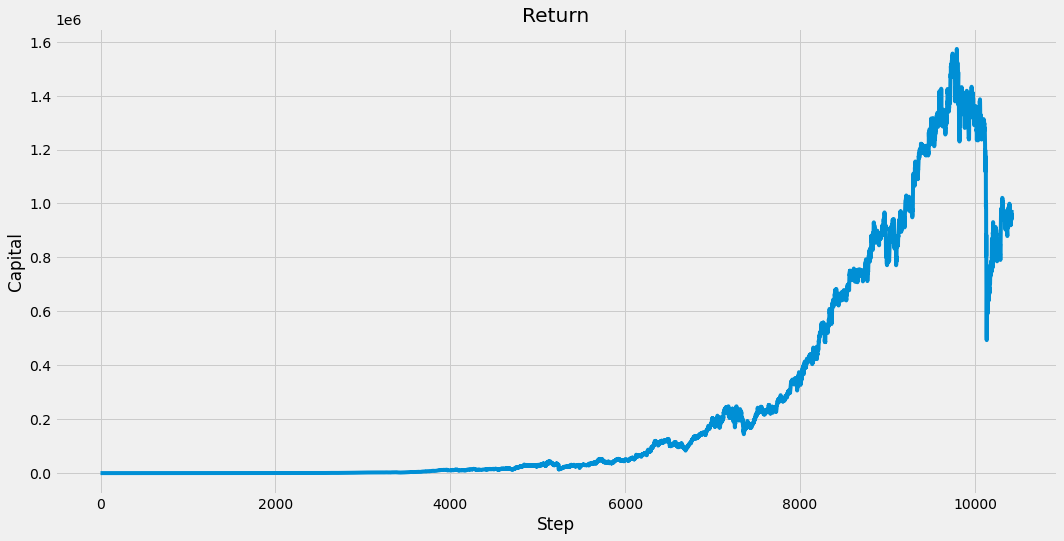

In [256]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

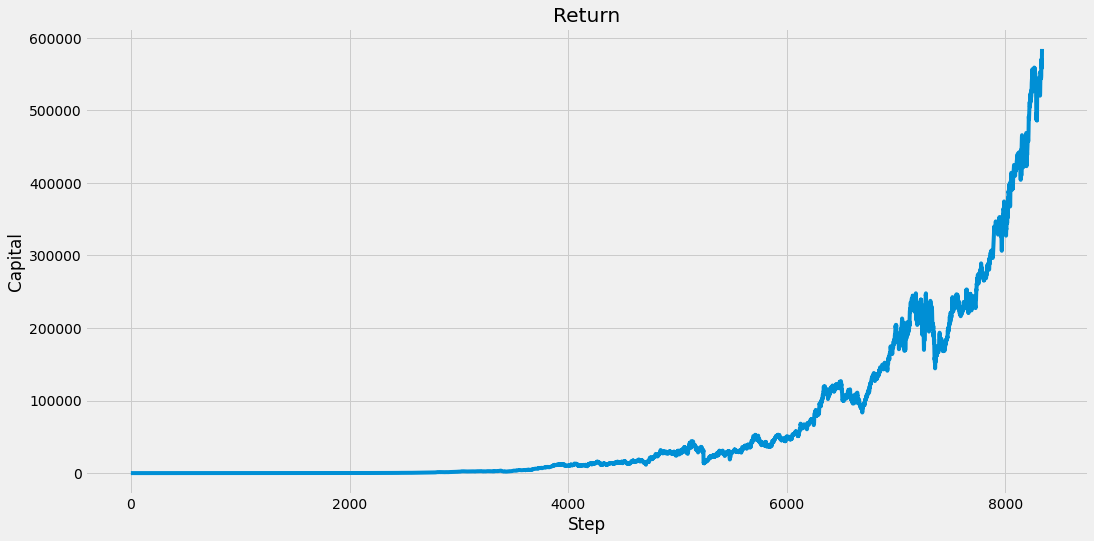

In [257]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[:int(len(result_sum_array)*0.8)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

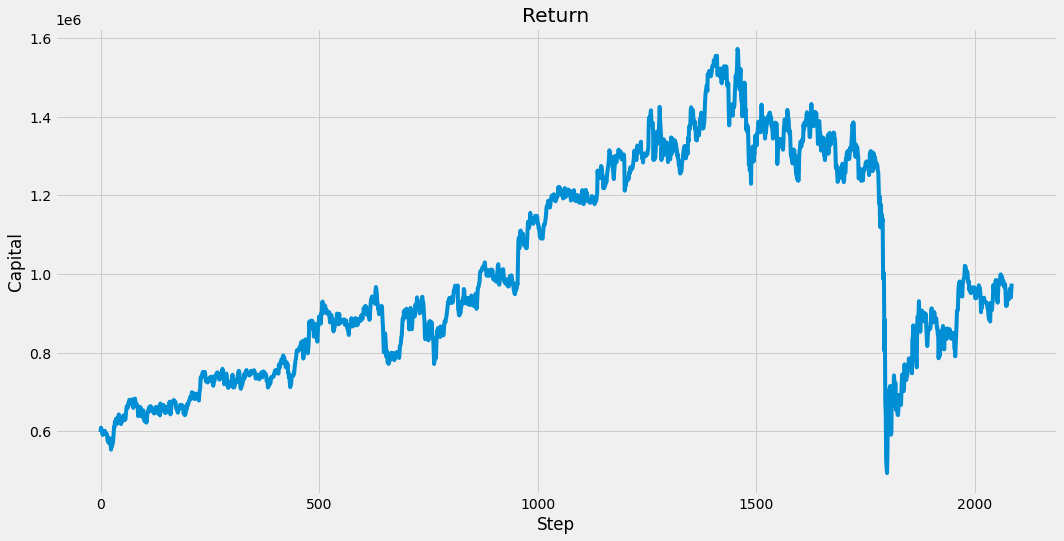

In [258]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[int(len(result_sum_array)*0.8):])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [259]:
window=5
result_sum=1.0
coef=0.8

In [260]:
result_sum=1.0
Y=[]

for i in range(window,len(df)-1):
    Y.append(EMA(df[:i],window,1.0/window)/df[i-1:i])

In [261]:
Y=np.array(Y).reshape(-1,np.array(Y).shape[2])

In [262]:
result_sum=1.0
result_sum_array=[]
# print(np.argmax(Y[0]))
# print(np.argmax(EMA(df[:5],window,1.0/window)/df[5-1:5]))
# print(df[df.columns[7]][5+1])
# print(df[df.columns[7]])
for i in range(len(Y)-1):
    index=np.argmax(Y[i])
    # print(df[window+i:window+i+5])
    result_sum*=df[df.columns[index]][window+i+1]/df[df.columns[index]][window+i]
    result_sum_array.append(result_sum)

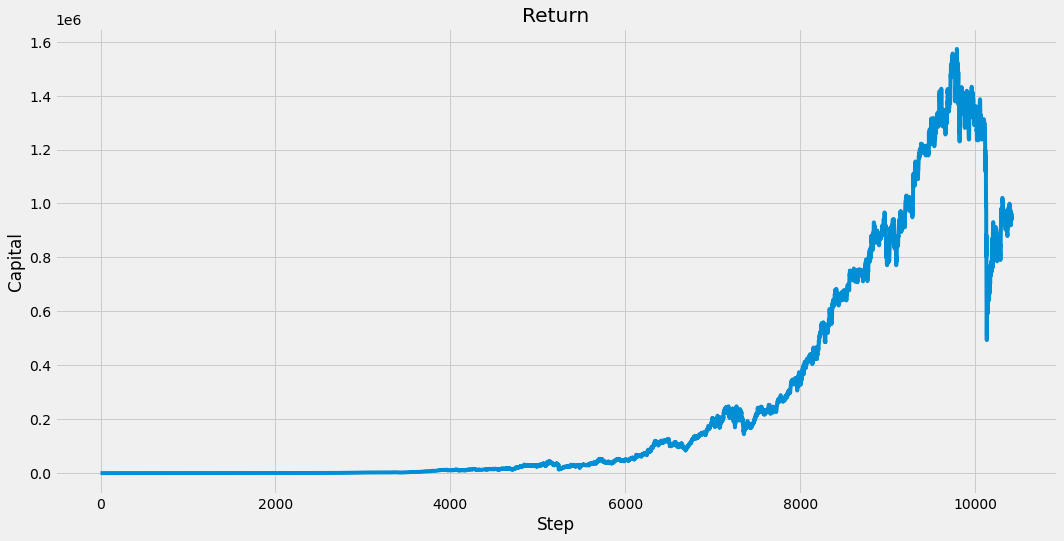

In [263]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

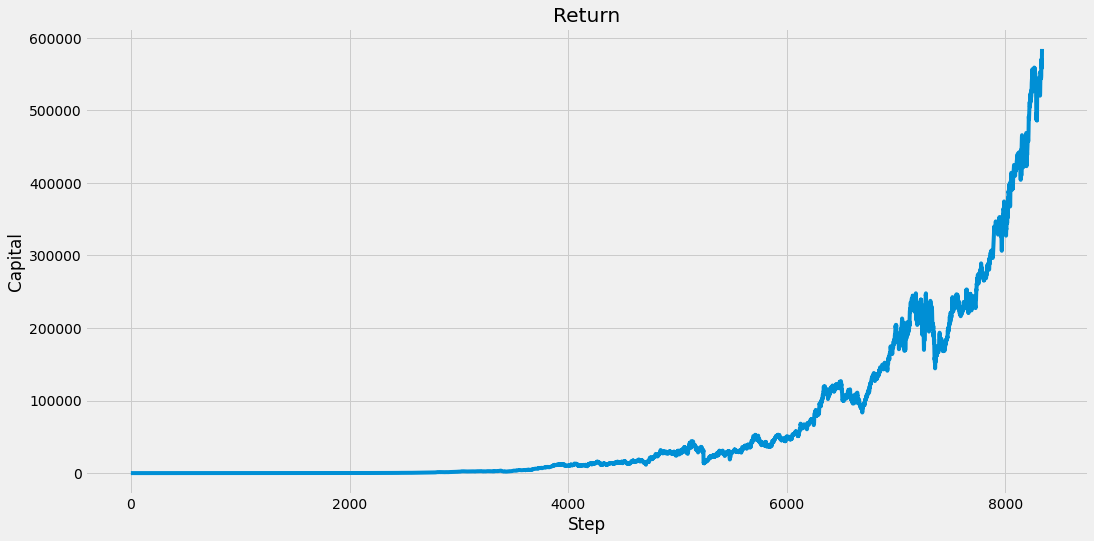

In [264]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[:int(len(result_sum_array)*coef)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

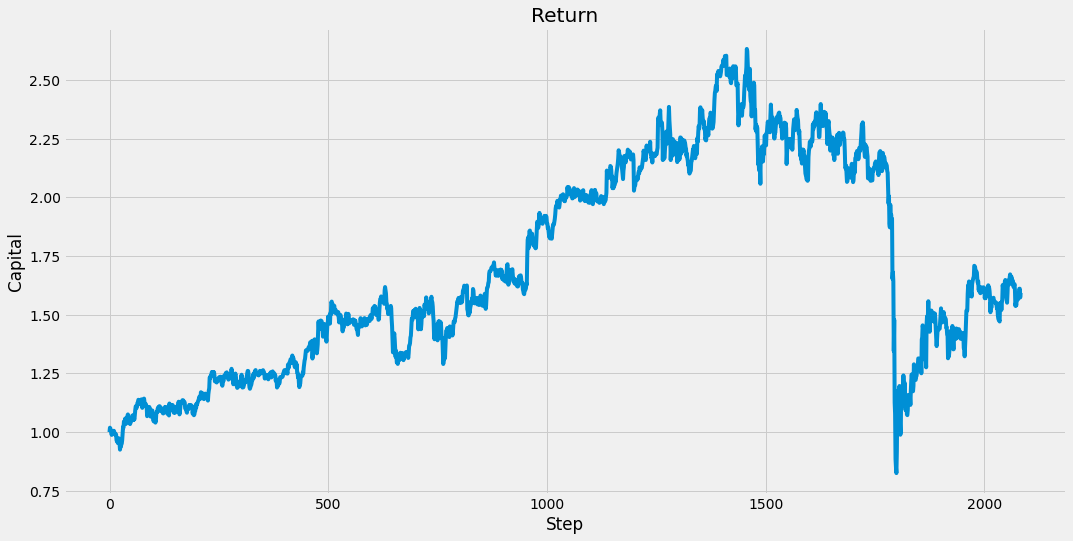

In [265]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[int(len(result_sum_array)*coef):]/result_sum_array[int(len(result_sum_array)*coef)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [321]:
Y_train=Y[:int(len(Y)*coef)]
Y_test=Y[int(len(Y)*coef):]
# print(Y[:int(len(Y)*coef)].shape)

In [267]:
Y_train[0]

array([0.67232001, 0.63804953, 0.6686529 , 0.65189351, 0.66581284,
       0.65735425, 0.65401376, 0.67232001, 0.64436885])

In [268]:
result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(Y_train)):
    
    index=np.argmax(Y_train[i])
    result_sum_train*=df[df.columns[index]][window+i+1]/df[df.columns[index]][window+i]
    # print(Y_train[i+1][index]/Y_train[i][index])
    result_sum_train_array.append(result_sum_train)

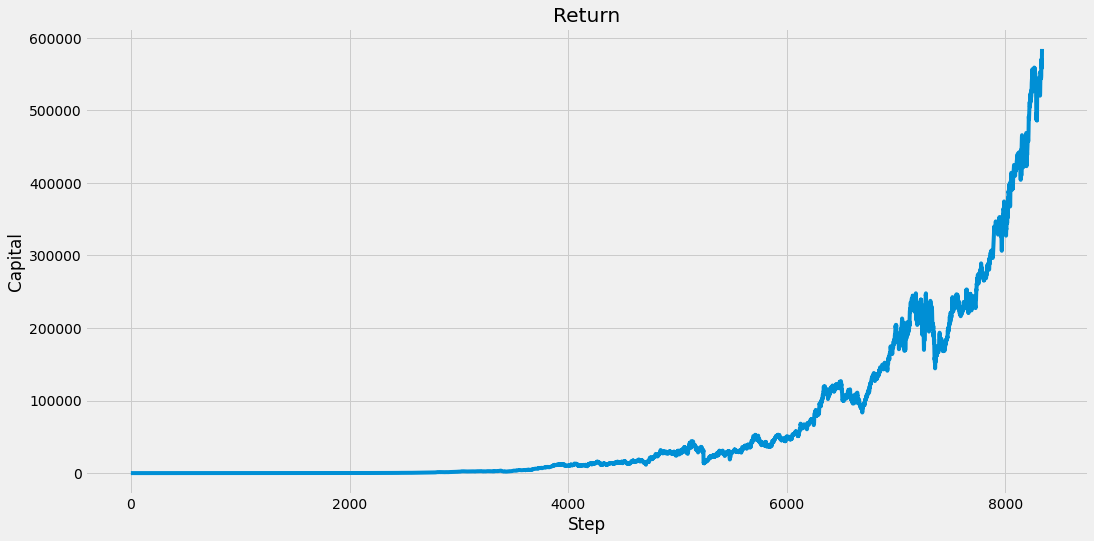

In [272]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [273]:
result_sum_test=1.0
result_sum_test_array=[]
# print(df[len(Y_train)-6:len(Y_train)-1])
# print(df[len(Y_train)-1:len(Y_train)])
# Y_test[1][0]
for i in range(len(Y_test)):
    
    index=np.argmax(Y_test[i])
    
    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

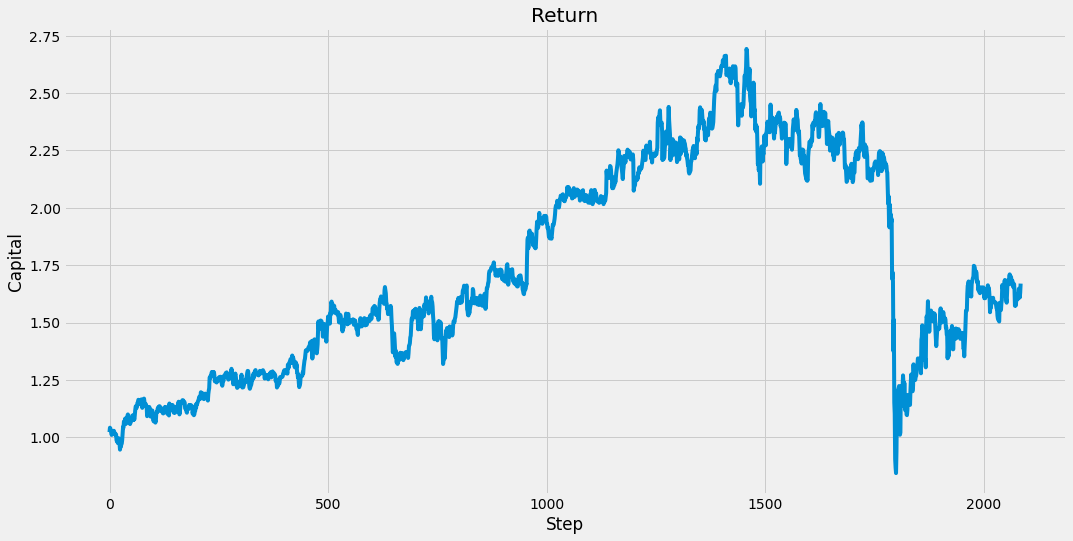

In [274]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [275]:
print(result_sum)
print(result_sum_train)
print(result_sum_test)

952158.8444275159
584307.3676085145
1.6696857325382333


#Подготовка X_train и X_test

In [373]:
Y_train=Y[:int(len(Y)*coef)]
Y_test=Y[int(len(Y)*coef):]

In [374]:
valid_size=0.1
X_train=[]
X_test=[]
X_valid=[]
Y_valid=[]

for i in range(window,len(Y_train)+window):
    X_train.append(df[i-window:i].values)
X_train=np.array(X_train)

X_valid=X_train[:int(len(X_train)*0.1)]
Y_valid=Y_train[:int(len(Y_train)*0.1)]

X_train=X_train[int(len(X_train)*0.1):]
Y_train=Y_train[int(len(Y_train)*0.1):]

for i in range(len(Y_train)+window,len(Y_test)+len(Y_train)+window):
    X_test.append(df[i-window:i].values)
X_test=np.array(X_test)

In [375]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(7503, 9)
(833, 9)
(2085, 9)


In [376]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(7503, 5, 9)
(833, 5, 9)
(2085, 5, 9)


In [377]:
X_train.shape

(7503, 5, 9)

In [378]:
X_train[0]

array([[0.162953, 2.701373, 2.079767, 1.2265  , 1.337896, 3.336788,
        0.710191, 0.192884, 0.524908],
       [0.177409, 2.726462, 2.101062, 1.245816, 1.361206, 3.407567,
        0.710191, 0.194324, 0.519448],
       [0.182228, 2.734826, 2.058474, 1.245816, 1.379852, 3.397455,
        0.710191, 0.195763, 0.514769],
       [0.178724, 2.759917, 2.051376, 1.252253, 1.370528, 3.442958,
        0.720791, 0.205839, 0.509309],
       [0.170401, 2.74319 , 2.058474, 1.242596, 1.365867, 3.397455,
        0.720791, 0.213036, 0.503069]], dtype=float32)

In [379]:
X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])[0]

array([0.162953, 2.701373, 2.079767, 1.2265  , 1.337896, 3.336788,
       0.710191, 0.192884, 0.524908, 0.177409, 2.726462, 2.101062,
       1.245816, 1.361206, 3.407567, 0.710191, 0.194324, 0.519448,
       0.182228, 2.734826, 2.058474, 1.245816, 1.379852, 3.397455,
       0.710191, 0.195763, 0.514769, 0.178724, 2.759917, 2.051376,
       1.252253, 1.370528, 3.442958, 0.720791, 0.205839, 0.509309,
       0.170401, 2.74319 , 2.058474, 1.242596, 1.365867, 3.397455,
       0.720791, 0.213036, 0.503069], dtype=float32)

In [380]:
X_train=X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
X_valid=X_valid.reshape(-1,X_valid.shape[1]*X_valid.shape[2])
X_test=X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])

# ANN learning

In [381]:
class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RegressionNet, self).__init__()
        self.fc1 = torch.nn.Linear(45, n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 9)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [382]:
X_train=torch.tensor(X_train)
X_valid=torch.tensor(X_valid)
X_test=torch.tensor(X_test)

Y_train=torch.tensor(Y_train)
Y_valid=torch.tensor(Y_valid)
Y_test=torch.tensor(Y_test)

In [383]:
X_train.shape

torch.Size([7503, 45])

In [384]:
net = RegressionNet(50)


X_train.unsqueeze_(1)
Y_train.unsqueeze_(1)

X_valid.unsqueeze_(1)
Y_valid.unsqueeze_(1)
# ------Dataset preparation end--------:


optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def loss(pred, target):
      abs = torch.abs(pred-target)
      return abs.mean()

for epoch_index in range(3000):
    optimizer.zero_grad()

    y_pred = net.forward(X_train)
    loss_value = loss(y_pred, Y_train)
    loss_value.backward()
    optimizer.step()
    # make backward
    # make step

In [406]:
y_train_pred=net.forward(X_train)
y_valid_pred=net.forward(X_valid)
y_test_pred=net.forward(X_test)

In [407]:
print(y_train_pred.shape)
print(y_valid_pred.shape)
print(y_test_pred.shape)

torch.Size([7503, 1, 9])
torch.Size([833, 1, 9])
torch.Size([2085, 9])


In [408]:
y_tr_pred=torch.cat((y_train_pred,y_valid_pred)).reshape(-1,y_train_pred.shape[2])

In [409]:
y_train_np=y_tr_pred.detach().numpy()
y_test_np=y_test_pred.detach().numpy()

# Проверка результативности

In [410]:
result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])
    result_sum_train*=df[df.columns[index]][window+i+1]/df[df.columns[index]][window+i]
    result_sum_train_array.append(result_sum_train)

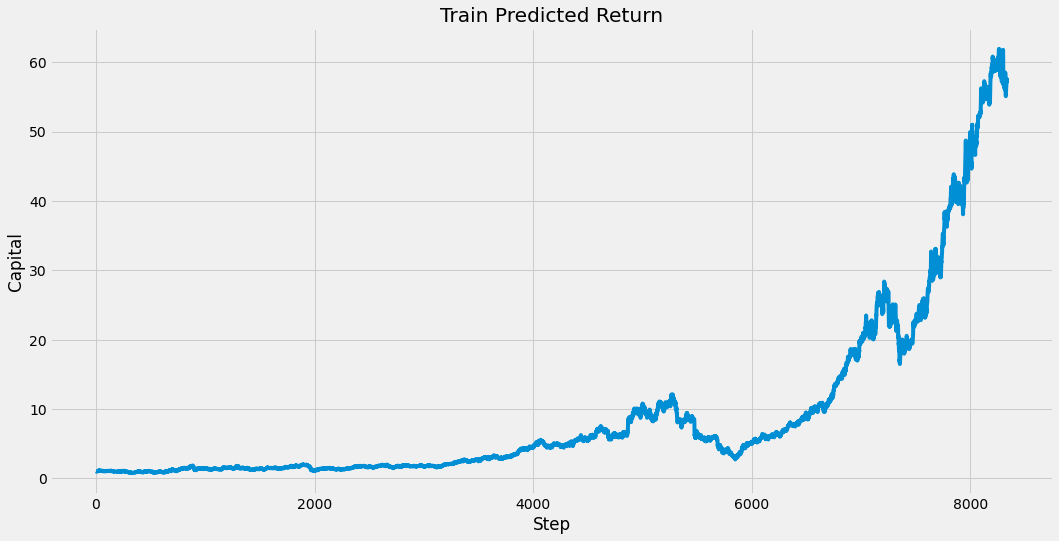

In [411]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [412]:
result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

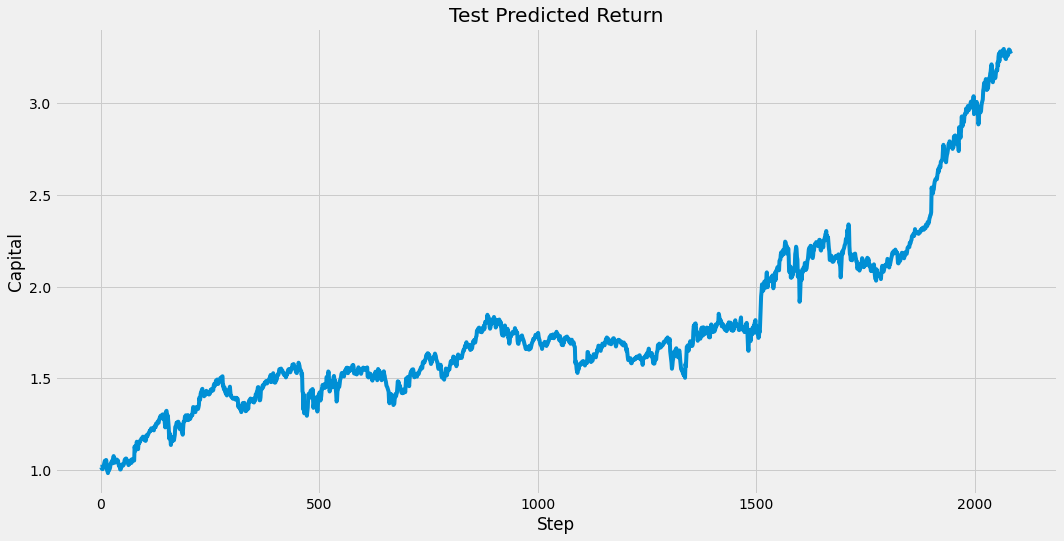

In [413]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()